## Clusterização

Neste notebook, tentamos através de uma técnica de clusterização encontrar características que possivelmente ajudam no surgimento de altas ou baixas frequências de nascimentos prematuros (será chamado apenas de FNP nos próximos comentários).

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Clusterização
# import hdbscan
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, PowerTransformer
from sklearn.metrics import classification_report

**Carregamento de dados preprocessados do SINASC e CADU, agrupados por id municipal**

In [2]:
df = pd.read_csv("/content/drive/My Drive/The Sound of Drums/Notebooks/data/pos_means1.csv")
df.sample()

,cd_ibge,idade,val_remuner_emprego_memb,val_renda_bruta_12_meses_memb,val_renda_doacao_memb,val_renda_aposent_memb,val_renda_seguro_desemp_memb,val_renda_pensao_alimen_memb,val_outras_rendas_memb,cod_sexo_pessoa_2,cod_raca_cor_pessoa_1.0,cod_raca_cor_pessoa_2.0,cod_raca_cor_pessoa_3.0,cod_raca_cor_pessoa_4.0,cod_raca_cor_pessoa_5.0,cod_local_nascimento_pessoa_1.0,cod_local_nascimento_pessoa_2.0,cod_local_nascimento_pessoa_3.0,cod_certidao_registrada_pessoa_1,cod_certidao_registrada_pessoa_2,cod_certidao_registrada_pessoa_3,cod_certidao_registrada_pessoa_4,cod_deficiencia_memb_1,cod_deficiencia_memb_2,cod_sabe_ler_escrever_memb_1.0,cod_sabe_ler_escrever_memb_2.0,ind_frequenta_escola_memb_1.0,ind_frequenta_escola_memb_2.0,ind_frequenta_escola_memb_3.0,ind_frequenta_escola_memb_4.0,cod_escola_local_memb_1.0,cod_escola_local_memb_2.0,cod_curso_frequenta_memb_1.0,cod_curso_frequenta_memb_2.0,cod_curso_frequenta_memb_3.0,cod_curso_frequenta_memb_4.0,cod_curso_frequenta_memb_5.0,cod_curso_frequenta_memb_6.0,cod_curso_frequenta_memb_7.0,cod_curso_frequenta_memb_8.0,...,cod_escoa_sanitario_domic_fam_6.0,cod_destino_lixo_domic_fam_1.0,cod_destino_lixo_domic_fam_2.0,cod_destino_lixo_domic_fam_3.0,cod_destino_lixo_domic_fam_4.0,cod_destino_lixo_domic_fam_5.0,cod_destino_lixo_domic_fam_6.0,cod_iluminacao_domic_fam_1.0,cod_iluminacao_domic_fam_2.0,cod_iluminacao_domic_fam_3.0,cod_iluminacao_domic_fam_4.0,cod_iluminacao_domic_fam_5.0,cod_iluminacao_domic_fam_6.0,cod_calcamento_domic_fam_1.0,cod_calcamento_domic_fam_2.0,cod_calcamento_domic_fam_3.0,cod_familia_indigena_fam_1,cod_familia_indigena_fam_2,ind_familia_quilombola_fam_1.0,ind_familia_quilombola_fam_2.0,ind_parc_mds_fam_0.0,ind_parc_mds_fam_101.0,ind_parc_mds_fam_201.0,ind_parc_mds_fam_202.0,ind_parc_mds_fam_203.0,ind_parc_mds_fam_204.0,ind_parc_mds_fam_205.0,ind_parc_mds_fam_301.0,ind_parc_mds_fam_302.0,ind_parc_mds_fam_303.0,ind_parc_mds_fam_304.0,ind_parc_mds_fam_305.0,ind_parc_mds_fam_306.0,marc_pbf_0,marc_pbf_1,cod_familia_indigena_fam_1.0,cod_familia_indigena_fam_2.0,ptb_rate,early_ptb_rate,extr_ptb_rate
3701,3539103,26.734043,149.648936,3039.975177,6.914894,11.0,0.0,6.382979,7.87234,1.0,0.340426,0.117021,0.0,0.531915,0.0,0.095745,0.882979,0.010638,0.87234,0.12766,0.0,0.0,0.0,1.0,0.989362,0.010638,0.170213,0.0,0.829787,0.0,0.159574,0.010638,0.0,0.0,0.0,0.0,0.042553,0.0,0.074468,0.010638,...,0.164557,0.924051,0.050633,0.025316,0.0,0.0,0.0,0.518987,0.101266,0.126582,0.0,0.0,0.253165,0.772152,0.075949,0.151899,0.0,1.0,0.0,1.0,0.974684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012658,0.35443,0.64557,0.0,0.0,0.001774,0.000161,0.000108


**Remoção de colunas que não agregam ao agrupamento**

In [3]:
df.drop(columns=['cd_ibge', 'id_familia', 'ind_parc_mds_fam', 'cod_parentesco_rf_pessoa', 
                 'cod_local_nascimento_pessoa', 'cod_certidao_registrada_pessoa', 
                 'ind_frequenta_escola_memb', 'cod_escola_local_memb'], inplace=True, errors='ignore')

**Remoção de municípios com frequências extremamente altas ou baixas de nascimentos prematuros**

Alguns dados, especialmente de municípios menores podem estar muito fora da curva

In [4]:
df = df[(df.ptb_rate < df.ptb_rate.quantile(0.95)) & (df.ptb_rate > df.ptb_rate.quantile(0.05))]

**Agrupamento por KMeans**

Foi utilizado um KMeans com 8 clusters, ponto inicial definido por k-means++. Foram removidos os valores-alvo de forma a tentar encontrar os clusters que melhor de ajustam ao conjunto de dados.

Foi também treinamento um algoritmo PCA para realizar uma visualização 3D dos grupos posteriormente.

In [29]:
km = KMeans(n_clusters=25)#, max_iter=1000000, tol=0.1)#Birch(n_clusters=16)#DBSCAN(.3, 20, 'cosine')#
pca = PCA(n_components=3)

x_feat = 'ptb_rate'

selection = df.copy()#.drop(columns=['ptb_rate', 'early_ptb_rate', 'extr_ptb_rate'])
selection[:] = MinMaxScaler().fit_transform(PowerTransformer().fit_transform(Normalizer().fit_transform(selection)))
pca.fit(selection)
km.fit(selection)
df2 = selection.copy()
df2['cluster'] = km.fit_predict(selection)
df2[['pca_f1', 'pca_f2', 'pca_f3']] = pca.fit_transform(selection)
df2['ptb_rate'] = df.ptb_rate

x = df2['pca_f1']
y = df2['pca_f2']
z = df2['pca_f3']# RobustScaler().fit_transform(df2[['ptb_rate']])
c = df2.cluster.astype('str')

In [30]:
pd.Series(km.labels_).unique()

array([13,  3, 18, 23,  4, 21, 12, 22,  7,  9, 14, 24,  1,  5, 11, 17,  8,
        6, 15,  0,  2, 16, 19, 20, 10], dtype=int32)

In [31]:
import plotly.express as px

fig = px.scatter_3d(x=x, y=y, z=z, color=c, opacity=1, width=1200, height=800)

fig.show()

Para cada cluster encontrado, observamos a distribuição de FNP separados em 10 faixas de frequências.

In [32]:
df2['Q'] = df2.ptb_rate.apply(lambda x : (x > df2.ptb_rate.quantile([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])).sum())

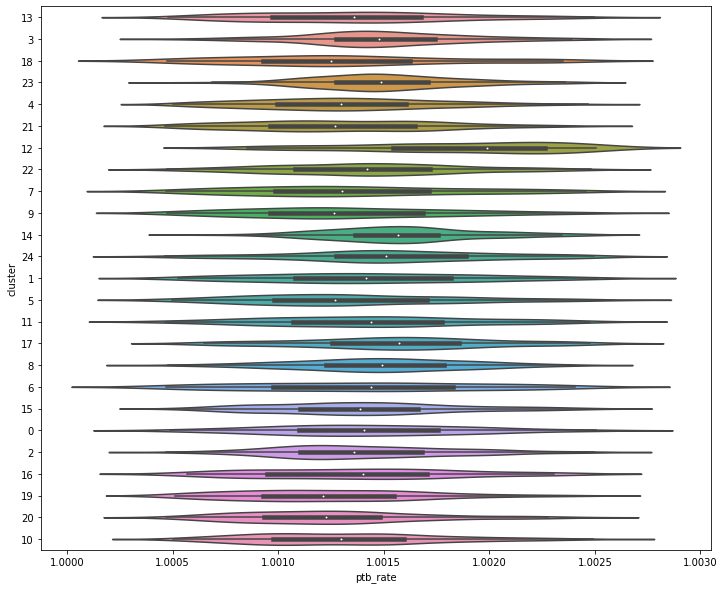

In [33]:
plt.subplots(figsize=(12,10))
sns.violinplot(x=np.exp(df2.ptb_rate), y=c)

plt.show()

In [34]:
distribuitions = df2.groupby(['cluster', 'Q'])[['ptb_rate']].count().div(df2.groupby(['cluster'])[['ptb_rate']].count()).reset_index().pivot(columns='Q', index='cluster', values='ptb_rate').fillna(0)

Aqueles grupos de municípios que tiverem mais que 45% de suas FNPs nas três faixas mais altas são tratados como grupos de FNP alto.

Já os grupos de municípios que tiverem mais que 45% de suas FNPs nas três faixas mais baixas são tratados como grupos de FNP baixo.

Regra sujeita a mudança.

In [37]:
large_ptb_rate_groups = distribuitions[(distribuitions[8] + distribuitions[9] + distribuitions[10] > 0.4)].index.values
small_ptb_rate_groups = distribuitions[(distribuitions[0] + distribuitions[1] + distribuitions[2] + distribuitions[3] > 0.4)].index.values

groups_to_analyse = list(large_ptb_rate_groups) + list(small_ptb_rate_groups)

Grupos de destaque, é possível observar no gráfico 3d acima que alguns destes clusters ficam muito bem definidos graficamente utilizando PCA.

In [38]:
df2.groupby(['cluster'])[['ptb_rate']].count().iloc[groups_to_analyse]

,ptb_rate
cluster,
12,83
14,162
17,123
10,264
19,135
20,189


É calculada a diferença média entre os clusters com valores de FNP altos e baixos em relação aos valores médios dos clusters "normais".

No teste abaixo, observa-se então as características que mais favorecem o aumento da FNP. E através do dicionário de variáveis do CADU, podemos descobrir o significado destas características. Ex.:

* cod_escoa_sanitario_fam_4 -> vala ou céu aberto
* cod_abaste_agua_domic_fam_2 -> poço ou nascente
* cod_agua_canalizada_fam_2 -> Não
* ind_familia_quilombola_fam_1 -> Sim
* cod_banheiro_domic_fam_2 -> Não
* cod_destino_lixo_domic_fam_3 -> Queimado ou enterrado na propriedade
* cod_destino_lixo_domic_fam_4 -> Jogado em terreno baldio ou logradouro
* cod_material_piso_fam_1 -> Terra
* cod_iluminacao_domic_fam_3 -> Elétrica sem medidor
* cod_iluminacao_domic_fam_4 -> Óleo/querosene/gás
* cod_calcamento_domic_fam_3 -> Não existe
* cod_agricultura_trab_memb_1 -> Sim (atividade extratisvista)
* cod_material_domic_fam_5 -> Taipa não revestida
* cod_destino_lixo_domic_fam_5 -> É jogado no rio/mar
* cod_raca_cor_pessoa_4 -> Parda
* cod_curso_frequenta_memb_5 -> Fundamental
* cod_curso_frequentou_pessoa_memb_1 -> Creche

In [39]:
mm = MinMaxScaler().fit(km.cluster_centers_)
large_centers = mm.transform(km.cluster_centers_[large_ptb_rate_groups]).mean(axis=0)
small_centers = mm.transform(km.cluster_centers_[small_ptb_rate_groups]).mean(axis=0)
other_centers = mm.transform(km.cluster_centers_[list(set(distribuitions.index) - set(large_ptb_rate_groups) - set(small_ptb_rate_groups))]).mean(axis=0)

In [40]:
arr = pd.Series((large_centers - other_centers))
arr.index = selection.columns

vdf1 = pd.DataFrame(arr.sort_values(ascending=False).head(50)).reset_index()
vdf1.columns = ['maior_destaque_pos', 'val_pos']

vdf2 = pd.DataFrame(arr.sort_values(ascending=False).tail(50).sort_values(ascending=True)).reset_index()
vdf2.columns = ['maior_destaque_neg', 'val_neg']

vdf = vdf1.join(vdf2)
vdf['pos'] = vdf.index+1
vdf.set_index('pos').head(20)

,maior_destaque_pos,val_pos,maior_destaque_neg,val_neg
pos,,,,
1,cod_destino_lixo_domic_fam_5.0,0.660351,cod_curso_frequentou_pessoa_memb_13.0,-0.346197
2,ind_parc_mds_fam_203.0,0.654442,cod_raca_cor_pessoa_1.0,-0.336132
3,cod_certidao_registrada_pessoa_3,0.607061,marc_pbf_0,-0.293616
4,cod_curso_frequenta_memb_9.0,0.494008,vlr_renda_media_fam,-0.273644
5,cod_curso_frequenta_memb_2.0,0.486414,cod_certidao_registrada_pessoa_2,-0.268589
6,ind_parc_mds_fam_202.0,0.447245,cod_abaste_agua_domic_fam_3.0,-0.255175
7,ind_parc_mds_fam_201.0,0.431941,cod_material_domic_fam_1.0,-0.239690
8,cod_material_domic_fam_7.0,0.431484,cod_material_piso_fam_5.0,-0.238495
9,cod_curso_frequenta_memb_14.0,0.426608,cod_deficiencia_memb_1,-0.229074


* cod_calcamento_domic_fam_2 -> Parcial
* cod_curso_frequentou_pessoa_memb_3 -> Alfabetização
* cod_iluminacao_domic_fam_6 -> Outra forma
* cod_escoa_sanitario_domic_fam_4 -> Vala a céu aberto
* cod_curso_frequentou_pessoa_memb_11 -> Fundamental II
* cod_destino_lixo_domic_fam_6 -> Outro destino
* cod_sabe_ler_escrever_memb_2 -> Não
* cod_curso_frequentou_pessoa_memb_10 -> Fundamental I
* cod_especie_domic_fam_3 -> Coletivo
* cod_local_domic_fam_2 -> Rurais
* cod_familia_indigena_fam_2 -> Não
* ind_familia_quilombola_fam_2 -> Não
* cod_raca_cor_pessoa_2 -> Preta
* cod_curso_frequentou_pessoa_memb_12 -> Ens. Médio
* cod_agricultura_trab_memb_1 -> Sim
* cod_abaste_agua_domic_fam_4 -> Outra forma
* cod_curso_frequenta_memb_2 -> Pré-escola

In [41]:
arr = pd.Series((small_centers - other_centers))
arr.index = selection.columns

vdf1 = pd.DataFrame(arr.sort_values(ascending=False).head(50)).reset_index()
vdf1.columns = ['maior_destaque_pos', 'val_pos']

vdf2 = pd.DataFrame(arr.sort_values(ascending=False).tail(50).sort_values(ascending=True)).reset_index()
vdf2.columns = ['maior_destaque_neg', 'val_neg']

vdf = vdf1.join(vdf2)
vdf['pos'] = vdf.index+1
vdf.set_index('pos').head(20)

,maior_destaque_pos,val_pos,maior_destaque_neg,val_neg
pos,,,,
1,cod_escoa_sanitario_domic_fam_1.0,0.450398,ind_parc_mds_fam_205.0,-0.404054
2,cod_iluminacao_domic_fam_2.0,0.418599,cod_escoa_sanitario_domic_fam_3.0,-0.351562
3,cod_escoa_sanitario_domic_fam_5.0,0.391813,cod_abaste_agua_domic_fam_4.0,-0.349119
4,val_renda_pensao_alimen_memb,0.313512,cod_iluminacao_domic_fam_6.0,-0.331424
5,cod_principal_trab_memb_4.0,0.292700,cod_curso_frequentou_pessoa_memb_14.0,-0.321875
6,cod_material_piso_fam_5.0,0.270345,cod_banheiro_domic_fam_2.0,-0.318060
7,cod_calcamento_domic_fam_1.0,0.164689,cod_escoa_sanitario_domic_fam_6.0,-0.313293
8,cod_raca_cor_pessoa_2.0,0.131949,cod_agua_canalizada_fam_2.0,-0.309005
9,marc_pbf_0,0.125415,cod_principal_trab_memb_7.0,-0.306115


In [42]:
from sklearn.manifold import TSNE

tsne = TSNE()

In [43]:
tsne_o = tsne.fit_transform(selection)

In [44]:
np.int64(df2.cluster.isin(large_ptb_rate_groups).values).sum()

368

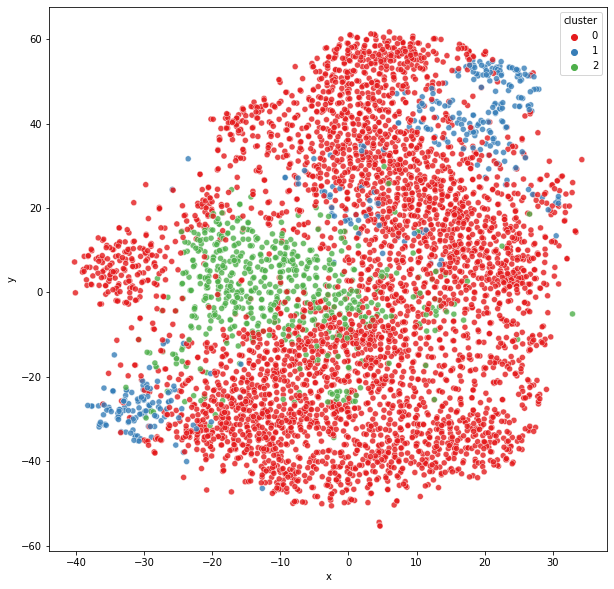

In [45]:
tsne_df = pd.DataFrame(tsne_o, columns=['x', 'y'])
tsne_df['ptb_rate'] = df2['ptb_rate'].values
tsne_df['cluster'] = np.int64(df2.cluster.isin(large_ptb_rate_groups).values) + 2*np.int64(df2.cluster.isin(small_ptb_rate_groups).values)#df2.cluster.values

tsne_df['c2'] = km.fit_predict(tsne_df)

plt.subplots(figsize=(10,10))
plt.subplot(111)
sns.scatterplot(data=tsne_df, x='x', y='y', hue='cluster', alpha=0.8, palette="Set1")

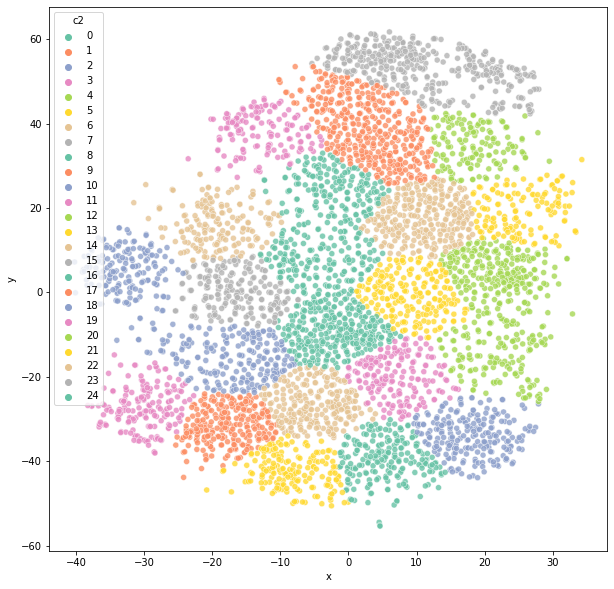

In [46]:
plt.subplots(figsize=(10,10))
plt.subplot(111)
sns.scatterplot(data=tsne_df, x='x', y='y', hue='c2', alpha=0.8, palette="Set2")

In [47]:
tsne_df['Q'] = tsne_df.ptb_rate.apply(lambda x : (x > tsne_df.ptb_rate.quantile([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])).sum())

In [48]:
dist2 = tsne_df.groupby(['cluster', 'Q'])[['ptb_rate']].count().div(tsne_df.groupby(['cluster'])[['ptb_rate']].count()).reset_index().pivot(columns='Q', index='cluster', values='ptb_rate').fillna(0)

In [49]:
large2 = dist2[(dist2[8] + dist2[9] + dist2[10] > 0.45)].index.values
small2 = dist2[(dist2[0] + dist2[1] + dist2[2] + dist2[3] > 0.45)].index.values
groups2 = list(large2) + list(small2)

tsne_df.groupby(['c2'])[['ptb_rate']].count().iloc[groups2]

,ptb_rate
c2,
1,193


In [50]:
mm = MinMaxScaler().fit(km.cluster_centers_)
large_centers = mm.transform(km.cluster_centers_[large2]).mean(axis=0)
small_centers = mm.transform(km.cluster_centers_[small2]).mean(axis=0)
other_centers = mm.transform(km.cluster_centers_[list(set(dist2.index) - set(large2) - set(small2))]).mean(axis=0)

ValueError: ignored

In [ ]:
arr = pd.Series((large_centers - other_centers))
arr.index = tsne_df.columns[:-2]

vdf1 = pd.DataFrame(arr.sort_values(ascending=False).head(50)).reset_index()
vdf1.columns = ['maior_destaque_pos', 'val_pos']

vdf2 = pd.DataFrame(arr.sort_values(ascending=False).tail(50).sort_values(ascending=True)).reset_index()
vdf2.columns = ['maior_destaque_neg', 'val_neg']

vdf = vdf1.join(vdf2)
vdf['pos'] = vdf.index+1
vdf.set_index('pos').head(20)

In [ ]:
tsne_df

In [ ]:
plt.subplots(figsize=(12,10))
sns.violinplot(x=tsne_df.ptb_rate, y=tsne_df.c2, orient='horizontal')

plt.show()